# Visualizing the Data

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

<IPython.core.display.Javascript object>

In [2]:
import scipy.io
import numpy as np
import pandas as pd
from addutils import css_notebook
css_notebook()

## 1 Principal Component Analysis (PCA)

Before trying any ML technique it is always a good idea to visualize the available data from different point of view but when the dimensionality of the problem is higher, it's difficult to use some that kind of plots and it is necessary to do **dimenionality reduction**.

We have already seen some simple visualization example made with scatter plot or scatter matrix on the tutorial ml01. In this lesson we're going furter by working with some of the mamy data projection techniques available in scikit-learn.

In the first example we will consider the *digits* dataset in which we have many 8x8 grayscale images of handwritten digits. In other words, this dataset is made by samples with 64 features

What we want to do is to obtain a descriptive 2D scatter plot.


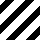
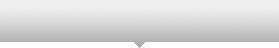
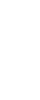
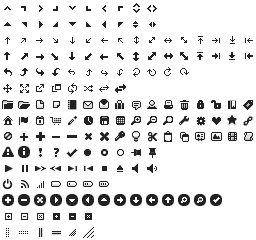
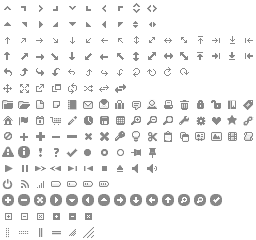
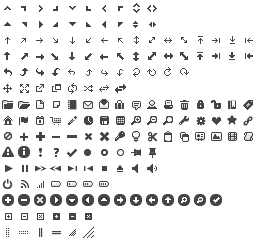
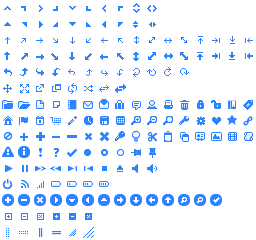
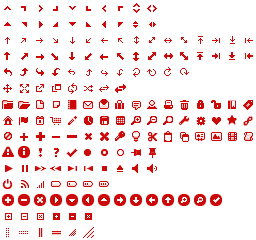
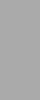
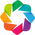
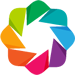
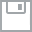
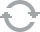
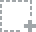
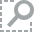
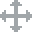
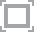
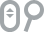

In [3]:
import bokeh.plotting as bk
bk.output_notebook()

In [4]:
from sklearn import datasets
digits = datasets.load_digits()

In [5]:
import addutils.imagegrid as ig
from bokeh.palettes import Greys9

num_imgs = digits.images.shape[0]
fig = ig.imagegrid_figure(images=[ digits.images[i][::-1, :] for i in range(num_imgs) ],
                          text=[ str(digits.target[i]) for i in range(num_imgs) ],
                          figure_title=None, palette=Greys9[::-1],
                          figure_plot_width=760, figure_plot_height=600,
                          text_color='red', padding=0.1,
                          grid_size=(10, 8))
bk.show(fig)

We'll start our analysis with Principal Component Analysis (PCA): PCA seeks orthogonal linear combinations of the features which show the greatest variance. In this example we'll use `RandomizedPCA`, because it's faster for large datasets.

In [6]:
import addutils.palette as pal
import seaborn as sns

In [7]:
from sklearn import decomposition

pca = decomposition.RandomizedPCA(copy=True, iterated_power=3, n_components=2, whiten=False)
pca_proj = pca.fit_transform(digits.data)

colors = map(pal.to_hex, sns.color_palette('Paired', 10))

fig = bk.figure(title='PCA Projection - digits dataset',
                x_axis_label='c1', y_axis_label='c2',
                plot_width=700, plot_height=560)
fig.scatter(pca_proj[:,0], pca_proj[:,1],
            size=10, fill_alpha=0.9, line_alpha=0.5, line_color='black',
            fill_color=pal.linear_map(digits.target, colors))
bk.show(fig)

We can notice some structure in this data but it's still difficult to understand if it would be possible to effectively apply some classification algorithm since the different data clusters do not show enough separation.

## 2 Linear Discriminant Analysis (LDA)

Principal Component Analysis (PCA) identifies the combination of attributes that account for the most variance in the data.

Linear Discriminant Analysis (LDA) instead tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, and can be used just when the class labels are available.

Let's see an LDA on the same Dataset:

**TODO -** Remove the warning

In [8]:
import warnings
warnings.filterwarnings('ignore', message='Variables are collinear')

from sklearn import lda
lda = lda.LDA(n_components=2)
lda_proj = lda.fit(digits.data, digits.target).transform(digits.data)

fig = bk.figure(title='LDA Projection - digits dataset', 
                x_axis_label='c1', y_axis_label='c2',
                plot_width=600, plot_height=480)
fig.scatter(lda_proj[:,0], lda_proj[:,1], 
            size=8, line_color='black', line_alpha=0.5,
            fill_color=pal.linear_map(digits.target, colors))
bk.show(fig)

As in the previous example we don't see a clear separation of the different clusters. This is because this specific dataset present some non-linear features that can not be separate by linear projections.

## 3 Manifold Learning

The main weakness of the linear techniques seen so far is that they cannot detect non-linear features.  A set of algorithms known as *Manifold Learning* have been developed to address this deficiency.

`Isomap` is a global, nonlinear, nonparametric dimentional reduction algorithm:

In [9]:
warnings.filterwarnings('ignore', message='kneighbors*')

from sklearn import manifold

fig_grid = []
for i in range(2):
    row = []
    for j in range(2):
        iso = manifold.Isomap(n_neighbors=i+2, n_components=2)
        proj = iso.fit_transform(digits.data)
        
        fig = bk.figure(title="n_neighbors = %d" % (i+2),
                        title_text_font_size='12pt',
                        plot_width=300, plot_height=300)
        fig.scatter(proj[:,0], proj[:,1], size=8, line_alpha=0.5, line_color='black',
                    fill_color=pal.linear_map(digits.target, colors))
        row.append(fig)
    fig_grid.append(row)

bk.show(bk.gridplot(fig_grid))

These visualizations show us that there is hope: even a simple classifier should be able to adequately identify the members of the various classes.

### 3.1 Another example un a specific test dataset: the S-Curve

A canonical dataset used in Manifold learning is the *S-curve*, which we briefly saw in an earlier section:

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

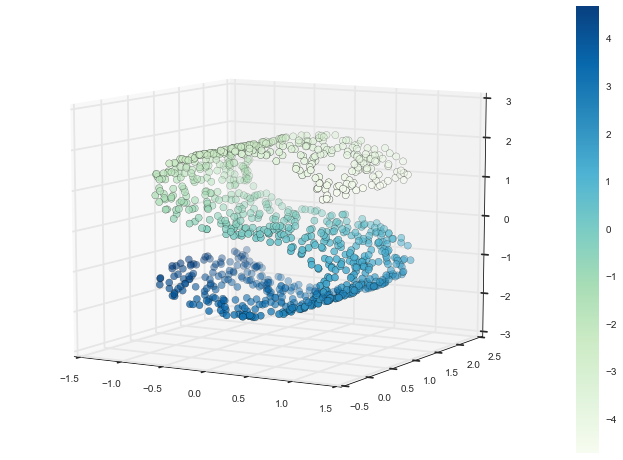

In [11]:
X, y = datasets.make_s_curve(n_samples=1000)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = plt.axes(projection='3d')
s = ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=50, marker="o", cmap='GnBu')
fig.colorbar(s)
ax.view_init(10, -60)

This is a 2-dimensional dataset embedded in three dimensions, but it is embedded in such a way that PCA cannot discover the underlying data orientation:

In [12]:
X_pca = decomposition.PCA(n_components=2).fit_transform(X)

seqcolors = map(pal.to_hex, sns.color_palette('GnBu', 50))
fig = bk.figure(title='PCA Projection - S-Curve',
               x_axis_label='c1', y_axis_label='c2', 
               plot_width=700, plot_height=500)
fig.scatter(X_pca[:, 0], X_pca[:, 1], 
            size=10, line_color='black', line_alpha=0.5,
                fill_color=pal.linear_map(y, seqcolors))
bk.show(fig)

Manifold learning algorithms, however, available in the `sklearn.manifold` submodule, are able to recover the underlying 2-dimensional manifold:

In [13]:
iso = manifold.Isomap(n_neighbors=25, n_components=2)
X_iso = iso.fit_transform(X)
fig = bk.figure(title='Isomap - S-Curve', x_axis_label='c1', y_axis_label='c2',
                plot_width=800, plot_height=400)
fig.scatter(X_iso[:, 0], X_iso[:, 1], size=8, alpha=0.8, line_color='black',
            fill_color=pal.linear_map(y, seqcolors))
bk.show(fig)

`LocallyLinearEmbedding` (LLE) is a local, nonlinear, nonparametric algorithm. The main idea behind the Local Algorithms is to make the local configurations of points in the low-dimensional space resemble the local configurations in the high-dimensional space.

In [14]:
lle = manifold.LocallyLinearEmbedding(n_neighbors=15, n_components=2, method='modified')
X_lle = lle.fit_transform(X)

fig = bk.figure(title='LocallyLinearEmbedding - S-Curve', x_axis_label='c1', y_axis_label='c2', 
                plot_width=800, plot_height=400)
fig.scatter(X_lle[:, 0], X_lle[:, 1],
            size=10, line_color='black', line_alpha=0.75,
            fill_color=pal.linear_map(y, seqcolors))
bk.show(fig)

### 3.2 Some Tips on Manifold Learning practical use

* Make sure the same scale is used over all features. Because manifold learning methods are based on a nearest-neighbor search, the algorithm may perform poorly otherwise.
* The reconstruction error can be used to choose the optimal output dimension. For a *d-dimensional* manifold embedded in a * D-dimensional* parameter space, the reconstruction error will decrease as n_components is increased until *n_components == d*.
* Noisy data can “short-circuit” the manifold, in essence acting as a bridge between parts of the manifold that would otherwise be well-separated.
* Certain input configurations can lead to singular weight matrices, for example when more than two points in the dataset are identical, or when the data is split into disjointed groups. In this case, solver='arpack' will fail to find the null space. The easiest way to address this is to use solver='dense', though it may be very slow depending on the number of input points.

### 3.3 t-SNE t-distribuited Stochastic Neighbor Embedding

`t-SNE` give more importance to local distances and lower importance to non-local distances. In other words, it try to keep closer in the projected space the points that are closer in the original space while neglecting the others.

Moreover `t-SNE` has a probabilistic way to find pairwise local distances: it converts each high-dimension similarity into the probability that one data point will pick one other data point as its neighbor. This make `t-SNE` almost insensitive to bad feature scaling.

On th other side, the relative local nature of `t-SNE` makes it sensitive to the course of the dimensionality of the data.

In [15]:
tsne = manifold.TSNE(n_components=2, n_iter=500)
tsne_proj = tsne.fit_transform(digits.data)

In [16]:
fig = bk.figure(title='t-SNE - digits dataset', x_axis_label='c1', y_axis_label='c2',
                plot_width=500, plot_height=380)
fig.scatter(tsne_proj[:,0], tsne_proj[:,1], size=8, line_color='black', line_alpha=0.5,
            fill_color=pal.linear_map(digits.target, colors))
bk.show(fig)

---

<img src="/files/resources/logo.png" > Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates